In [1]:
import os

In [2]:
os.chdir("../../../")

In [3]:
import json
from operator import itemgetter

from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate, HumanMessagePromptTemplate, ChatPromptTemplate, SystemMessagePromptTemplate
from langchain.output_parsers import StructuredOutputParser, ResponseSchema
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import chain
from langchain.retrievers import BM25Retriever
from langchain.docstore.document import Document

from src.initialization import credential_init
from src.io.path_definition import get_project_dir


credential_init()

model = ChatOpenAI(openai_api_key=os.environ['OPENAI_API_KEY'],
                   model_name="gpt-4o", temperature=0)


with open(os.path.join(get_project_dir(), 'tutorial', 'LLM+Langchain', 'Week-1', 'recipe_train.json'), 'r') as f:
    recipe_train = json.load(f)

with open(os.path.join(get_project_dir(), 'tutorial', 'LLM+Langchain', 'Week-1', 'recipe_test.json'), 'r') as f:
    recipe_test = json.load(f)

In [4]:
def build_standard_chat_prompt_template(kwargs):

    system_content = kwargs['system']
    human_content = kwargs['human']
    
    system_prompt = PromptTemplate(**system_content)
    system_message = SystemMessagePromptTemplate(prompt=system_prompt)
    
    human_prompt = PromptTemplate(**human_content)
    human_message = HumanMessagePromptTemplate(prompt=human_prompt)
    
    chat_prompt = ChatPromptTemplate.from_messages([system_message,
                                                     human_message
                                                   ])

    return chat_prompt


## Find out all the ingredients and cluster them according to some rules.

- Do you still remember the joke-analysis chain? This one is structurally identical.

In [5]:
documents = []

for recipe in recipe_train:
    document = Document(page_content=", ".join(recipe['ingredients']),
                        metadata={"cuisine": recipe['cuisine'],
                                  "id": recipe['id']})
    documents.append(document)

retriever = BM25Retriever.from_documents(documents=documents)
    
output_parser = StrOutputParser()

query = ", ".join(recipe_test[5]['ingredients'])

question = "Show me all the ingredients."

In [6]:
query

'hamburger buns, jalapeno chilies, avocado, garlic powder, chili powder, reduced-fat sour cream, dried oregano, chile pepper, cilantro leaves, cheddar cheese, ground black pepper, ground chicken breast, salt, pepper, green onions, shredded lettuce, salsa'

In [7]:
# first level chain

system_template = "You are an AI assistant as the best chef in the world."

human_template = ("Answer the question based only on the following content:\n"
                  "{context}\n\n"
                  "Question: {question}"
                 )

input_ = {"system": {"template": system_template},
          "human": {"template": human_template,
                    "input_variable": ["context", "question"]}}

chat_prompt_template_1 = build_standard_chat_prompt_template(input_)

user_input = {"context": itemgetter("query")|retriever, 
              "question":itemgetter("question")}

pipeline_1 = user_input | chat_prompt_template_1 | model | output_parser

In [8]:
print(pipeline_1.invoke({"question": question,
                         "query": query}))

Here are all the ingredients listed in the documents:

1. Sliced tomatoes
2. Cheddar cheese
3. Kosher salt
4. Coarse salt
5. Onions
6. Tomatoes
7. Hamburger buns
8. Jalapeno chilies
9. Fresh lemon juice
10. Ground cumin
11. Avocado
12. Mayonnaise
13. Fresh cilantro
14. Shredded lettuce
15. Dried oregano
16. Corn tortilla chips
17. Black pepper
18. Chili powder
19. Ground beef
20. Seasoning salt
21. Chopped cilantro
22. Salsa verde
23. Cream cheese
24. Garlic powder
25. Olives
26. Shredded cheddar cheese
27. Green onions
28. Sour cream
29. Pepper
30. Ground turkey breast
31. Salt
32. Seasoned black beans
33. Cumin
34. Green bell pepper
35. Garlic cloves
36. Black beans
37. Picante sauce
38. Frozen corn
39. Brown rice
40. Cilantro leaves
41. Bay leaf
42. Green chile
43. Vegetable broth


In [9]:
# second level chain

response_schemas = [
        ResponseSchema(name="result", 
                       description="""
                                   a python dictionary with structure
                                   <PYTHON STR>: <PYTHON LIST> 
                                   """)]

structured_output_parser = StructuredOutputParser.from_response_schemas(response_schemas)

format_instructions = structured_output_parser.get_format_instructions()

system_template = """
                  You are an AI assistant as the best chef in the world. 
                  """

human_template = """
                 Please sort through the {ingredients}, such as meat, 
                 scipy, milk product,..., etc; 
                 format instruction: {format_instructions}
                 """

input_ = {"system": {"template": system_template},
          "human": {"template": human_template,
                    "input_variable": ["ingredients"],
                    "partial_variables": {"format_instructions": 
                                           format_instructions}}}

chat_prompt_template_2 = build_standard_chat_prompt_template(input_)

In [10]:
pipeline_ = {"ingredients": pipeline_1}|chat_prompt_template_2|model|structured_output_parser

In [11]:
pipeline_.invoke({"query": query, "question": question})

{'result': {'Vegetables': ['Sliced tomatoes',
   'Tomatoes',
   'Onions',
   'Jalapeno chilies',
   'Avocado',
   'Shredded lettuce',
   'Green onions',
   'Green bell pepper',
   'Green chile'],
  'Cheese': ['Cheddar cheese', 'Shredded cheddar cheese', 'Cream cheese'],
  'Spices and Seasonings': ['Kosher salt',
   'Coarse salt',
   'Ground cumin',
   'Dried oregano',
   'Black pepper',
   'Chili powder',
   'Seasoning salt',
   'Garlic powder',
   'Salt',
   'Cumin',
   'Pepper',
   'Bay leaf'],
  'Herbs': ['Fresh cilantro', 'Chopped cilantro', 'Cilantro leaves'],
  'Condiments and Sauces': ['Mayonnaise', 'Salsa verde', 'Picante sauce'],
  'Proteins': ['Ground beef',
   'Ground turkey breast',
   'Seasoned black beans',
   'Black beans'],
  'Other': ['Hamburger buns',
   'Fresh lemon juice',
   'Corn tortilla chips',
   'Olives',
   'Sour cream',
   'Garlic cloves',
   'Frozen corn',
   'Brown rice',
   'Vegetable broth']}}

## 回家自行練習
1. 自己找一個中文食譜，打開冰箱掃一下。把冰箱裡的東西作為`現有食材`輸入，食譜中的某道菜作為`建議食材`輸入
2. Find out all the ingredients and cluster them according to some rules -> 轉換成中文下去做。

## OpenAI WebSearch Part1

- Basic Usage

In [12]:
from openai import OpenAI

client = OpenAI(api_key=os.environ['OPENAI_API_KEY'])

response = client.chat.completions.create(
        model="gpt-4o-search-preview",
        web_search_options={"search_context_size": "high"},
        messages=[{"role": "user",
                   "content": "What is the reciprocal tariff imposed by the United State of America?"}]
    )

In [13]:
response.choices[0].message.content

'In April 2025, the United States implemented a "reciprocal tariff" policy aimed at addressing perceived trade imbalances. This policy introduced a two-tiered tariff system:\n\n1. **Baseline Tariff**: Effective April 5, 2025, a universal 10% ad valorem tariff was imposed on imports from nearly all countries. ([whitehouse.gov](https://www.whitehouse.gov/presidential-actions/2025/04/regulating-imports-with-a-reciprocal-tariff-to-rectify-trade-practices-that-contribute-to-large-and-persistent-annual-united-states-goods-trade-deficits/?utm_source=openai))\n\n2. **Country-Specific Tariffs**: Starting April 9, 2025, higher tariffs were applied to imports from countries with which the U.S. had significant trade deficits. These rates were calculated using a formula that divided the U.S. trade deficit with each country by the total imports from that country, then halved the result. For example:\n\n   - **China**: 34%\n   - **European Union**: 20%\n   - **Vietnam**: 46%\n   - **Japan**: 24%\n   

In [14]:
response.choices[0].message.annotations[0].url_citation.url

'https://www.whitehouse.gov/presidential-actions/2025/04/regulating-imports-with-a-reciprocal-tariff-to-rectify-trade-practices-that-contribute-to-large-and-persistent-annual-united-states-goods-trade-deficits/?utm_source=openai'

In [15]:
def openai_web_search_fn(input_: str, model):

    response = client.chat.completions.create(
        model="gpt-4o-search-preview",
        web_search_options={"search_context_size": "high"},
        messages=[{"role": "user",
                   "content": input_}]
    )

    return response

- Slightly more advanced way.

In [16]:
from functools import partial
from typing import Optional

from langchain_core.runnables import RunnablePassthrough, RunnableLambda

response_schemas = [
        ResponseSchema(name="refined_query", 
                       description="The refined search query")]

output_parser = StructuredOutputParser.from_response_schemas(response_schemas)
format_instructions = output_parser.get_format_instructions()


class OpenAIWebSearch:

    def __init__(self, model: str, temperature: Optional[float]=0):

        """
        output: response.output_text
        citations: response.output[1].content[0].annotations
        """

        self._model = ChatOpenAI(openai_api_key=os.environ['OPENAI_API_KEY'],
                                 model_name=model, temperature=temperature)

        self.web_search_pipeline = RunnableLambda(partial(openai_web_search_fn, model=model))
        self.query_generation_pipeline = self._build_query_generation_pipeline()

        self.pipeline = RunnablePassthrough.assign(context=self.query_generation_pipeline|self.web_search_pipeline)

    def _build_query_generation_pipeline(self):

        input_ = {"system": {"template": ("You are a highly intelligent AI assistant specialized in refining and optimizing search queries.\n"
                                          "Your goal is to generate precise, well-structured, and effective web search queries that maximize "
                                          "relevant and accurate results.")},
                  "human": {"template": ("Help me generate an optimized web search query based on the following question: {question}.\n"
                                         "Ensure the query is clear, specific, and structured to retrieve the most relevant information efficiently.\n"
                                         "format instruction: {format_instructions}"),
                            "input_variables": ['question'],
                            "partial_variables": {'format_instructions': format_instructions}}}

        chat_prompt_template = build_standard_chat_prompt_template(input_)

        return chat_prompt_template|self._model|output_parser|itemgetter("refined_query")

In [17]:
websearch = OpenAIWebSearch(model='gpt-4o')

output = websearch.pipeline.invoke({"question": "What is the reciprocal tariff imposed by the United State of America?"})

In [18]:
output

{'question': 'What is the reciprocal tariff imposed by the United State of America?',
 'context': ChatCompletion(id='chatcmpl-e7059c98-2f20-4d1a-b90f-81b8ba09c58e', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='In 2023, the United States did not impose any new reciprocal tariffs. The most significant development in U.S. trade policy occurred in April 2025, when President Donald Trump announced a comprehensive tariff strategy aimed at addressing trade imbalances. This strategy, often referred to as the "Liberation Day" tariffs, introduced a two-tiered system:\n\n1. **Global Tariff:** A universal 10% ad valorem duty was applied to all imports into the United States, effective April 5, 2025. ([whitehouse.gov](https://www.whitehouse.gov/presidential-actions/2025/04/regulating-imports-with-a-reciprocal-tariff-to-rectify-trade-practices-that-contribute-to-large-and-persistent-annual-united-states-goods-trade-deficits/?utm_source=openai))

In [ ]:
# context = output['context']

In [ ]:
# print(context.choices[0].message.content)

In [ ]:
# output = websearch.pipeline.invoke({"question": "What is the reciprocal tariffs in International Trade imposed by the United State of America?"})
# context = output['context']
# print(context.choices[0].message.content)

## Perplexity

https://python.langchain.com/docs/integrations/chat/perplexity/

- sonar-deep-research
- sonar-reasoning-pro
- sonar-reasoning
- sonar-pro
- sonar	128k
- r1-1776

In [ ]:
messages = [
    {
        "role": "system",
        "content": (
            "You are an AI assistant that focuses on equity market analysis and you need to "
            "engage in an accurate, comprehensive, helpful and  polite conversation with a user."
        ),
    },
    {  
        "role": "user",
        "content": (
            "Find the SKU number of Carslan Lasting Cover Foundation N01"
        ),

    },

]

client = OpenAI(api_key=os.environ['PERPLEXITY_API_KEY'], base_url="https://api.perplexity.ai")

# response = client.chat.completions.create(
#     model="sonar-deep-research",
#     messages=messages,
# )

# print(response)

In [ ]:
# print(response.choices[0].message.content)

- Langchain modification

In [19]:
from langchain_core.messages import SystemMessage, HumanMessage


@chain
def prompt_template_2_messages(chat_prompt):

    output_messages = []
     
    _messages = chat_prompt.messages

    for message in _messages:
        if isinstance(message, SystemMessage):
            output_messages.append({"role": "system", "content": message.content})
        if isinstance(message, HumanMessage):
            output_messages.append({"role": "user", "content": message.content})

    return output_messages


@chain
def messages_2_perplexity(messages):

    client = OpenAI(api_key=os.environ['PERPLEXITY_API_KEY'], base_url="https://api.perplexity.ai")

    response = client.chat.completions.create(
        model="sonar-deep-research",
        messages=messages
    )

    content = response.choices[0].message.content
    citations = response.citations

    return {"content": content,
            "citations": citations}

In [20]:
system_prompt = PromptTemplate(template=("You are an AI assistant that focuses on equity market analysis and you need to "
                                "engage in an accurate, comprehensive, helpful and  polite conversation with a user."
                               ))
system_message = SystemMessagePromptTemplate(prompt=system_prompt)

human_prompt = PromptTemplate(template="find out the report earnings of Bloomberg ticker {ticker}",
                              input_variable=["ticker"])
human_message = HumanMessagePromptTemplate(prompt=human_prompt)

chat_prompt_perplexity = ChatPromptTemplate.from_messages([system_message,
                                                           human_message
                                                           ])

In [21]:
pipeline_perplexity = chat_prompt_perplexity|prompt_template_2_messages|messages_2_perplexity

In [22]:
pipeline_perplexity.invoke({"ticker": '2382 HK'})

{'content': '<think>\nWe are given a query: "find out the report earnings of Bloomberg ticker 2382 HK"\n The ticker 2382 HK refers to Sunny Optical Technology (Group) Company Limited, listed on the Hong Kong Stock Exchange.\n\n We have multiple search results that provide earnings information for this company.\n\n Steps:\n 1. Identify the most recent earnings reports from the search results.\n 2. Extract the earnings per share (EPS) and net profit figures for the latest reported periods.\n 3. Note that the company reports in RMB (Chinese Yuan) and sometimes in HKD (Hong Kong Dollars). We must be cautious of the currency.\n\n From the search results:\n\n [1] This is a report dated 10 Mar 2022. It provides historical earnings up to FY21E and forecasts for FY22E and FY23E. However, this is outdated.\n\n [2] This is a company profile from MarketScreener. It provides financials for 2025 and 2026 (projections). The table shows net sales and net income in billions (presumably CNY). For 2025*,

## DeepSeek

In [ ]:
from langchain_deepseek import ChatDeepSeek

In [ ]:
deepseek_r1 = ChatDeepSeek(api_key=os.environ['DEEPSEEK_API_KEY'], temperature=0, model='deepseek-reasoner')

system_template = "You are a helpful assistant."
human_template = "Create a financial report of {ticker} based on:\n {context}"

input_ = {"system": {"template": system_template},
          "human": {"template": human_template,
                    "input_variable": ["context", "ticker"]}
         }

chat_prompt_deepseek = build_standard_chat_prompt_template(input_)

pipeline_deepseek = chat_prompt_deepseek|deepseek_r1|output_parser

## Combining the Deep Search of Perplexity and Reasoning of DeepSeek-R1 

- Langchain Framework

In [ ]:
from operator import itemgetter

final_pipeline = RunnablePassthrough.assign(context=pipeline_perplexity|itemgetter("content"))|pipeline_deepseek

# Types of Classification (分類類型)

There are two main types (主要有兩種類型):

- Sorting by feelings (Sentiment Classification)
- Sorting by category (Category Classification)
- 按感覺排序（情感分類）
- 按類別排序（類別分類）

## How it Works (工作原理):

- We use a method called supervised learning. This means we have data and labels. Labels are like tags that tell us what the data is about. These labels are usually created by people who look at the data and decide what it means.
- 我們使用一種稱為監督學習的方法。這意味著我們有數據和標籤。標籤告訴我們數據是什麼。這些標籤通常由查看數據並決定其含義的人創建。

把每一組數據想像成是(題目，答案)的組合，靠著瘋狂刷題(大數據)來學習如何從題目得到答案。
Aka: 填鴨式教育。填鴨其實不差，起碼鴨會肥。

## Challenges

- It takes a long time.
- It's not always done the same way by different people.
- It's expensive.
- Training the model often needs renting cloud services like AWS or Azure.
- Using these cloud services for running the model also costs a lot.
- 耗時： 標記數據需要很長時間。
- 不一致： 不同的人可能會以不同的方式標記相同的數據。
- 昂貴： 該過程成本高昂。
- 資源密集型： 訓練模型通常需要租用雲服務，如 AWS 或 Azure。
- 運營成本： 使用這些雲服務運行模型的成本也很高。

## Can we mimic supervised learning classification with LLM (我們能否用大型語言模型模仿監督學習分類)?

- Yes, we can use large language models (LLMs) to mimic supervised learning classification. LLMs, like GPT-3 or GPT-4, can be trained to understand and generate human-like text. They can be fine-tuned on specific tasks, such as classification, without the need for extensive labeled datasets.
- 是的，我們可以使用大型語言模型（LLM）來模仿監督學習分類。像 GPT-3 或 GPT-4 這樣的 LLM 可以被訓練來理解和生成類似人類的文本。它們可以針對特定任務進行微調，例如分類，而不需要大量標記數據集。

## Zero-Shot

In [23]:
from IPython.display import Image

Image(url="https://substackcdn.com/image/fetch/w_1456,c_limit,f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fb157d0e9-d18e-4835-a601-edeb011f0ee6_721x247.png")

## 飛安事故原因分類

In [24]:
import pandas as pd

df = pd.read_excel(os.path.join(get_project_dir(), 'tutorial', 'LLM+Langchain', 'Week-3', 'Data sample.xlsx'))

In [25]:
df.head(5)

,,Time,Time.1,Place,Place.1,Place.2,Place.3,Place.4,Place.5,Place.6,...,Events.3,Events.4,Events.5,Assessments,Assessments.1,Report 1,Report 1.1,Report 2,Report 2.1,Report 1.2
0,ACN,Date,Local Time Of Day,Locale Reference,State Reference,Relative Position.Angle.Radial,Relative Position.Distance.Nautical Miles,Altitude.AGL.Single Value,Altitude.MSL.Single Value,Latitude / Longitude (UAS),...,Detector,When Detected,Result,Contributing Factors / Situations,Primary Problem,Narrative,Callback,Narrative,Callback,Synopsis
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1714708,202001,0601-1200,ZZZ.Airport,US,NaN,NaN,0,NaN,NaN,...,Person Dispatch,In-flight,General None Reported / Taken,Procedure; Logbook Entry; Human Factors,Ambiguous,I had a ferry flight that went out of service ...,NaN,We departed ZZZ ferrying an un-airworthy aircr...,NaN,Air carrier Dispatcher and flight crew reporte...
3,1715238,202001,0001-0600,L30.TRACON,NV,NaN,NaN,NaN,5000,NaN,...,Person Air Traffic Control,In-flight,Air Traffic Control Issued New Clearance,Airspace Structure; Human Factors,Human Factors,Aircraft X was inbound to the airport from the...,NaN,NaN,NaN,L30 TRACON Controller reported they issued VFR...
4,1715405,202001,1201-1800,ZZZ.Airport,US,NaN,NaN,NaN,3000,NaN,...,Automation Air Traffic Control; Person Air Tra...,In-flight,Air Traffic Control Issued Advisory / Alert; F...,Weather; Human Factors,Human Factors,Approaching ZZZ at about XA:55. ATIS indicated...,NaN,NaN,NaN,EMB-505 flight crew received a low altitude al...


In [26]:
df.iloc[5]

                                                        1715871
Time                                                     202001
Time.1                                                0601-1200
Place                                               ZZZ.Airport
Place.1                                                      US
                                    ...                        
Report 1      This incident occurred shortly after XA:00 loc...
Report 1.1                                                  NaN
Report 2                                                    NaN
Report 2.1                                                  NaN
Report 1.2    C525 single pilot reported a runway excursion ...
Name: 5, Length: 125, dtype: object

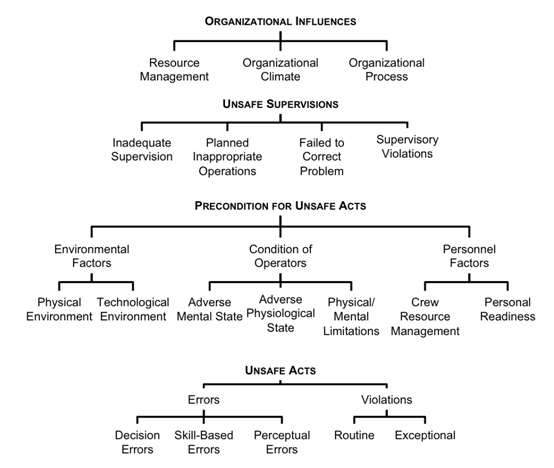

In [27]:
from IPython.display import Image

Image(filename= "tutorial/LLM+Langchain/Week-3/HFACS_Org_Inf.jpg")

In [28]:
system_template = """
                  You are an AI assistant assigned with a task of safty report 
                  classification based on the content. You are a seasoned 
                  flight safety inspector with deep and extensive knowledge of 
                  aviation safty. 
    
                  You always do the best work you can. You are highly 
                  analytical and pay close attention to details. 
    
                  The candidates of the output are:

                  - `Organizational Influence;Resource Management`
                  - `Organizational Influence;Organizational Climate`
                  - `Organizational Influence;rganizational Process`
                  - `Unsafe Supervisions;Inadequate Supervision`
                  - `Unsafe Supervisions;Planned Inappropriate Operations`
                  - `Unsafe Supervisions;Failed to Correct Problem`
                  - `Unsafe Supervisions;Supervisory Violation`
                  - `Precondition for Unsafe Acts;Environmental Factors;Physical Environment`
                  - `Precondition for Unsafe Acts;Environmental Factors;Technological Environment`
                  - `Precondition for Unsafe Acts;Condition of Operators;Adverse Mental State`
                  - `Precondition for Unsafe Acts;Condition of Operators;Adverse Physiological State`
                  - `Precondition for Unsafe Acts;Condition of Operators;Physical/Mental Limitations`
                  - `Precondition for Unsafe Acts;Personnel Factors;Crew Resource Management`
                  - `Precondition for Unsafe Acts;Personnel Factors;Personal Readiness`
                  - `Unsafe Acts;Errors;Decision Errors`
                  - `Unsafe Acts;Errors;Skill-Based Errors`
                  - `Unsafe Acts;Errors;Perceptual Errors`
                  - `Unsafe Acts;Violations;Routine`
                  - `Unsafe Acts;Violations;Exceptional`
            
                 The output is from one of the candidates. 
                 """

human_template = "{report}"

input_ = {"system": {"template": system_template},
          "human": {"template": human_template,
                    "input_variable": ["report"]}}

chat_prompt_template = build_standard_chat_prompt_template(input_)

pipeline_ = chat_prompt_template | model | StrOutputParser()

In [29]:
text = df.iloc[3]['Report 1']

print(text)

Aircraft X was inbound to the airport from the southeast. Apparently the aircraft was on an IFR flight plan and I completely overlooked that information. It took the aircraft traveling about 10 miles inside my airspace before the pilot called and made first contact with me. When the pilot finally called me and told me he had the current ATIS I had asked the pilot which route he wanted to take inbound to North Las Vegas airport. Again, I failed to look at all the information in the data block and treated him as if he was VFR. When I asked the pilot which route he wanted and he was open to either route, I gave the aircraft a clearance through the Class Bravo airspace and assigned a heading of 270 with no altitude assigned. A minute or so later I asked the pilot if he was familiar with the local flying area and the surrounding terrain, and after he replied in the affirmative, I instructed the pilot to resume own navigation then fly heading 360.After I got that read back, I instructed the 

- Do you want to read it by yourself or do you want to outsource this to a machine?

In [30]:
output = pipeline_.invoke({"report": text})

print(output)

`Unsafe Acts;Errors;Decision Errors`


### 使用parser精煉結果

In [31]:
response_schemas = [
        ResponseSchema(name="category", 
                       description="""
                                   The predicted category of the classification
                                   """)]

output_parser = StructuredOutputParser.from_response_schemas(response_schemas)
format_instructions = output_parser.get_format_instructions()

system_template = """
                  You are an AI assistant assigned with a task of safty report 
                  classification based on the content. You are a seasoned 
                  flight safety inspector with deep and extensive knowledge of 
                  aviation safty. 
    
                  You always do the best work you can. You are highly 
                  analytical and pay close attention to details. 
    
                  The candidates of the output are:

                  - `Organizational Influence;Resource Management`
                  - `Organizational Influence;Organizational Climate`
                  - `Organizational Influence;rganizational Process`
                  - `Unsafe Supervisions;Inadequate Supervision`
                  - `Unsafe Supervisions;Planned Inappropriate Operations`
                  - `Unsafe Supervisions;Failed to Correct Problem`
                  - `Unsafe Supervisions;Supervisory Violation`
                  - `Precondition for Unsafe Acts;Environmental Factors;Physical Environment`
                  - `Precondition for Unsafe Acts;Environmental Factors;Technological Environment`
                  - `Precondition for Unsafe Acts;Condition of Operators;Adverse Mental State`
                  - `Precondition for Unsafe Acts;Condition of Operators;Adverse Physiological State`
                  - `Precondition for Unsafe Acts;Condition of Operators;Physical/Mental Limitations`
                  - `Precondition for Unsafe Acts;Personnel Factors;Crew Resource Management`
                  - `Precondition for Unsafe Acts;Personnel Factors;Personal Readiness`
                  - `Unsafe Acts;Errors;Decision Errors`
                  - `Unsafe Acts;Errors;Skill-Based Errors`
                  - `Unsafe Acts;Errors;Perceptual Errors`
                  - `Unsafe Acts;Violations;Routine`
                  - `Unsafe Acts;Violations;Exceptional`
            
                 The output is from one of the candidates. 
                 """

human_template = """
                 {report}; 
                 format instruction: {format_instructions}
                 """


input_ = {"system": {"template": system_template},
          "human": {"template": human_template,
                    "input_variable": ["report"],
                    "partial_variables": {'format_instructions': format_instructions}}}

chat_prompt_template = build_standard_chat_prompt_template(input_)

pipeline_ = chat_prompt_template|model|output_parser

In [32]:
output = pipeline_.invoke({"report": text})

In [33]:
output

{'category': 'Unsafe Acts;Errors;Decision Errors'}

### 回家作業 1

若要飛安事故報告可以有複數分類結果，如何調整Prompt，包含parser

In [34]:
df.filter(like='Report')

,Report 1,Report 1.1,Report 2,Report 2.1,Report 1.2
0,Narrative,Callback,Narrative,Callback,Synopsis
1,NaN,NaN,NaN,NaN,NaN
2,I had a ferry flight that went out of service ...,NaN,We departed ZZZ ferrying an un-airworthy aircr...,NaN,Air carrier Dispatcher and flight crew reporte...
3,Aircraft X was inbound to the airport from the...,NaN,NaN,NaN,L30 TRACON Controller reported they issued VFR...
4,Approaching ZZZ at about XA:55. ATIS indicated...,NaN,NaN,NaN,EMB-505 flight crew received a low altitude al...
5,This incident occurred shortly after XA:00 loc...,NaN,NaN,NaN,C525 single pilot reported a runway excursion ...
6,Captain/PF (Pilot Flying) requested 2000 ft. b...,NaN,NaN,NaN,EMB-505 F/O reported returning to departure ai...
7,We were scheduled to do a flight from with 4 p...,NaN,NaN,NaN,Corporate pilot reported deicing truck did not...
8,I was in the traffic pattern in a C172 with a ...,NaN,NaN,NaN,Flight instructor reported that while on the d...
9,This incident occurred on the second of two tr...,NaN,NaN,NaN,A flight instructor distracted by a student st...


### 回家作業 2

你可以很清楚的看到一個飛安事故中，可以出現複數報告。
將`Report 1` 和 `Report 1.2` 結合起來產生一份的新報告。

抄也是一門技術

# **** 預計第一個小時結束 ****

## HR: Job-Applicant Matching

- Efficiency and Speed: LLMs can quickly process and analyze large volumes of applications, significantly reducing the time required for initial screening compared to manual reviews.

- Consistency and Fairness: LLMs apply the same criteria consistently across all applications, minimizing human bias and ensuring a fairer initial screening process.

- Detailed Analysis: LLMs can analyze complex language patterns and extract relevant information from resumes, cover letters, and other application materials, identifying key skills and qualifications that match job requirements.

- Customization and Flexibility: LLMs can be customized to prioritize different skills and experiences based on specific job requirements, allowing for a more tailored screening process.

- Scalability: LLMs can handle a large number of applications simultaneously, making them ideal for organizations that receive high volumes of applicants.

- Cost-Effectiveness: By automating the initial stages of applicant screening, LLMs can reduce the need for extensive human resources, thereby lowering operational costs.

- Continuous Improvement: LLMs can be continuously trained and improved based on feedback and new data, enhancing their accuracy and effectiveness over time.

- Enhanced Candidate Experience: Faster response times and more consistent evaluations can improve the overall candidate experience, as applicants are more likely to receive timely feedback.

- 效率和速度： LLMs 能夠快速處理和分析大量申請，相較於人工審查，顯著縮短初步篩選所需的時間。

- 一致性和公平性： LLMs 對所有申請應用相同的標準，最小化人為偏見，確保初步篩選過程的公平性。

- 詳細分析： LLMs 能夠分析複雜的語言模式，從簡歷、求職信和其他申請材料中提取相關信息，識別符合工作要求的關鍵技能和資格。

- 自定義和靈活性： LLMs 可以根據具體的工作要求自定義優先考慮的技能和經驗，允許更有針對性的篩選過程。

- 可擴展性： LLMs 能夠同時處理大量申請，非常適合接收大量申請人的組織。

- 成本效益： 通過自動化申請篩選的初始階段，LLMs 可以減少對大量人力資源的需求，從而降低運營成本。

- 持續改進： LLMs 可以根據反饋和新數據持續進行訓練和改進，隨著時間的推移提高其準確性和有效性。-

- 提升候選人經驗： 更快的回應時間和更一致的評估可以改善整體候選人經驗，因為申請人更有可能及時收到反饋。

In [35]:
from IPython.display import IFrame

IFrame("https://www.techjobasia.com/zh-Hant/jobs/GMMlhU0qSayr6ZwTB0U6zA---Software-Engineer-(ReactJS)", width=800, height=400)

###  1. Send a GET request to the URL (發送 GET 請求到指定的 URL)

- This line sends an HTTP GET request to the specified URL and stores the response in the response variable.
- 這行程式碼向指定的 URL 發送 HTTP GET 請求，並將響應儲存在 response 變數中。

In [36]:
import requests

from bs4 import BeautifulSoup
from langchain_community.document_loaders import BSHTMLLoader

url = "https://www.techjobasia.com/zh-Hant/jobs/GMMlhU0qSayr6ZwTB0U6zA---Software-Engineer-(ReactJS)"

# Send a GET request to the URL
response = requests.get(url)

In [37]:
response

<Response [200]>

### 2. Get the content of the response (獲取響應的內容)

- This line extracts the content of the response as a text string and stores it in the html_content variable.
- 這行程式碼將響應的內容作為文字字串提取，並將其儲存在 html_content 變數中。

In [38]:
html_content = response.text

In [ ]:
# html_content

### 3. Parse the HTML content (解析 HTML 內容)

- This line uses BeautifulSoup to parse the HTML content stored in html_content, creating a BeautifulSoup object named soup.
- 這行程式碼使用 BeautifulSoup 解析儲存在 html_content 中的 HTML 內容，並創建一個名為 soup 的 BeautifulSoup 對象。

In [39]:
soup = BeautifulSoup(html_content, 'html.parser')

In [ ]:
# soup

### 4. Remove all CSS style tags (移除所有 CSS 樣式標籤)

- This loop finds all <style> tags in the parsed HTML content and removes them using the decompose() method.
- 這個循環找到解析後的 HTML 內容中的所有 <style> 標籤，並使用 decompose() 方法將它們移除。

In [40]:
for style in soup.find_all('style'):
    style.decompose()

### 6. Extract and print only the text content (提取並打印僅包含文字的內容)

- This line extracts the text content from the parsed HTML, separating elements with a newline character, and stores it in the text_content variable.
- 這行程式碼從解析後的 HTML 中提取文字內容，使用換行符將元素分隔，並將其儲存在 text_content 變數中。

In [41]:
text_content = soup.get_text(separator='\n')

In [42]:
text_content

"\n\n\n\nSoftware Engineer (ReactJS) Opening at Bridgespace Group in 南區, 香港 | Apply now at TechJobAsia\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n搜尋工作\n資訊及攻略\n立即開始\n立即開始\n招聘者專區\n工作\n/\nBridgespace Group\n/\nSoftware Engineer (ReactJS)\nSoftware Engineer (ReactJS)\nBridgespace Group\nSoftware Engineer (ReactJS)\nBridgespace Group\n軟件工程師\n南區, 香港\n7 天前\n全職\n辦公室工作\n科技、資訊和媒體\n收藏\n工作描述\n7 天前\nWho we are:\nWe are currently hiring a few permanent positions to serve its portfolio companies and other projects industry wide.\nResponsibilities\nAs a software engineer, you will be part of a dynamic team of p

### 7. Clean up the text (清理文字內容)

- This line cleans up the extracted text by removing any leading or trailing whitespace from each line and discarding empty lines. The cleaned text is stored in the cleaned_text variable.
- prints the cleaned text content to the console.
- 這行程式碼通過移除每行的首尾空白並丟棄空行來清理提取的文字內容。清理後的文字儲存在 cleaned_text 變數中。
- 將清理後的文字內容打印到控制台。

In [ ]:
# for line in text_content.splitlines():
#     if line.strip():
#         print(line.strip())

In [43]:
cleaned_text = '\n'.join(line.strip() for line in text_content.splitlines() if line.strip())

print(cleaned_text)

Software Engineer (ReactJS) Opening at Bridgespace Group in 南區, 香港 | Apply now at TechJobAsia
搜尋工作
資訊及攻略
立即開始
立即開始
招聘者專區
工作
/
Bridgespace Group
/
Software Engineer (ReactJS)
Software Engineer (ReactJS)
Bridgespace Group
Software Engineer (ReactJS)
Bridgespace Group
軟件工程師
南區, 香港
7 天前
全職
辦公室工作
科技、資訊和媒體
收藏
工作描述
7 天前
Who we are:
We are currently hiring a few permanent positions to serve its portfolio companies and other projects industry wide.
Responsibilities
As a software engineer, you will be part of a dynamic team of professionals using cutting-edge technologies and agile methodology to deliver scalable, testable and maintainable software.
You will actively participate in our development life cycle, working on new user stories, to review, design implement and test.
Analyse and understand problems, to ensure solutions meet overall consistency and satisfaction.
You will be working independently and improving yourself with up-to-date technologies.
Qualifications
• Candidate must possess a

### Extract only the job related content

In [44]:
template= """
          Extract the job description part of the text: {content} 
          """

human_prompt = PromptTemplate(template=template)
human_message = HumanMessagePromptTemplate(prompt=human_prompt)
    
chat_prompt_template = ChatPromptTemplate.from_messages([human_message])

pipeline_ = chat_prompt_template|model|StrOutputParser()

job_description = pipeline_.invoke({"content": cleaned_text})

print(job_description)

**Job Description for Software Engineer (ReactJS) at Bridgespace Group**

**Who we are:**
We are currently hiring a few permanent positions to serve our portfolio companies and other projects industry-wide.

**Responsibilities:**
- As a software engineer, you will be part of a dynamic team of professionals using cutting-edge technologies and agile methodology to deliver scalable, testable, and maintainable software.
- You will actively participate in our development life cycle, working on new user stories, to review, design, implement, and test.
- Analyse and understand problems to ensure solutions meet overall consistency and satisfaction.
- You will be working independently and improving yourself with up-to-date technologies.

**Qualifications:**
- Candidate must possess at least a Diploma, Advanced/Higher/Graduate Diploma, or Bachelor's degree.
- 4+ years of experience in front-end development using ReactJS.
- Strong proficiency in JavaScript, HTML5, and CSS3.
- Experience with resp

Let us do the same thing for the ten following candidates

In [45]:
applicants = ["https://www.hiredchina.com/profiles/c87dc713-deea-408a-8798-c4e0814fc3ce",
              "https://www.hiredchina.com/profiles/de4d4802-d58b-4d0a-92f6-b0f999ff2617",
              "https://www.hiredchina.com/profiles/64cecea3-4f68-4707-89fa-c10dd9889be8",
              "https://www.hiredchina.com/profiles/708fa8bc-0ccf-4f93-8be6-14154bfe828d",
              "https://www.hiredchina.com/profiles/3ce4f0fb-c93f-4e87-aa00-1d75badce875",
              "https://www.hiredchina.com/profiles/2aa145b8-cad0-4682-a542-8bbe0d268d74",
              "https://www.hiredchina.com/profiles/06b2343a-a1ea-42da-bbfb-318041ae0835",
              "https://www.hiredchina.com/profiles/3daf0124-ad33-4a9c-8305-28428bbf5ffc",
              "https://www.hiredchina.com/profiles/053e6b20-0dee-477a-9fb6-3ab27e69206b",
              "https://www.hiredchina.com/profiles/27f68cab-1f20-432b-9157-4f473c2ec189"]

In [47]:
from langchain_core.runnables import chain, Runnable


def parsing_process(url):
    """
    Fetches and extracts text content from a given URL.

    Parameters:
    url (str): The URL of the web page to fetch and parse.

    Returns:
    str: Cleaned text content extracted from the web page.

    Raises:
    requests.exceptions.RequestException: If an error occurs while fetching the URL.

    Notes:
    - This function sends a GET request to the specified URL.
    - It uses BeautifulSoup to parse the HTML content of the response.
    - Any <style> tags in the HTML are removed to extract only textual content.
    - The extracted text is cleaned by removing extra whitespace and empty lines.
    """
    
    
    # Send a GET request to the URL
    response = requests.get(url)

    # Get the content of the response
    html_content = response.text
    
    soup = BeautifulSoup(html_content, 'html.parser')
    
    for style in soup.find_all('style'):
        style.decompose()

    # Extract and print only the text content
    text_content = soup.get_text(separator='\n')

    # Clean up the text (optional)
    cleaned_text = '\n'.join(line.strip() for line in text_content.splitlines() if line.strip())
    
    return cleaned_text

In [48]:
IFrame(applicants[0], width=800, height=400)

In [49]:
print(parsing_process(applicants[0]))

Romain resume | HiredChina - Jobs in China for Foreigners
Login/Sign up
EN
/
中文
Jobs
Candidates
Articles
Login
Sign up
EN
/
中文
/
Mobile development engineer
/
Current
/
Romain
Mobile app developer
25 years old
Mobile development engineer
Come from
France
Living in France - Lille
Language
:
French
,
English
Mandarin
:
not at all
Share
Share
Summary
My name is Romain, I'm a french mobile app developer with 3 years of experience who has graduated from Epitech.
I helped start-ups and bigger companies to upgrade their products.
I am willing to find new challenges, work on creative and innovative projects in China.
Experience
Flutter developer
Fastlane Educations
Nov 2022
-
Aug 2023
(9 months)
Co-designing the application within an agile team.
Developing the Speechlab application in Flutter from scratch.
Deploying the application on stores (AppStore, PlayStore).
Managing CI/CD for the application.
Flutter developer
Symbol-it
Apr 2022
-
Nov 2022
(7 months)
Development of a mobile application 

In [ ]:
# print(parsing_process("https://www.freelancer.com/u/divyadhakecha1"))

### Extract the Resume

In [50]:
from langchain_core.output_parsers import StrOutputParser


system_template = """
                  I am going to give you a template for your output. 
                  CAPITALIZED WORDS are my placeholders. 
                  Fill in my placeholders with your output. Please preserve 
                  the overall formatting of my template. My template is:

                  *** Working Experience:*** WORKING EXPERIENCE 
                  *** Education:*** EDUCATION
                  *** Skills:*** SKILLS

                  I will give you the data to format in the next prompt. 
                  Create a resume using my template.
                  """

human_template = """
                 {query}
                 """

input_ = {"system": {"template": system_template},
          "human": {"template": human_template,
                    "input_variable": ["query"]}}

resume_prompt_template = build_standard_chat_prompt_template(input_)

resume_pipeline = {"query": parsing_process}|resume_prompt_template|model|StrOutputParser()

In [51]:
resume_output = resume_pipeline.invoke(applicants[0])

In [52]:
print(resume_output)

*** Working Experience:*** 
- **Flutter Developer, Fastlane Educations**  
  Nov 2022 - Aug 2023 (9 months)  
  - Co-designed the application within an agile team.
  - Developed the Speechlab application in Flutter from scratch.
  - Deployed the application on stores (AppStore, PlayStore).
  - Managed CI/CD for the application.

- **Flutter Developer, Symbol-it**  
  Apr 2022 - Nov 2022 (7 months)  
  - Developed a mobile application for La Pioche.
  - Developed a mobile application for Fastlane Education.

- **Flutter Developer, GAAP Solutions**  
  Oct 2021 - May 2022 (7 months)  
  - Migrated from Flutter 1 to Flutter 2.
  - Migrated from Flutter mobile to Flutter web.
  - Integrated a payment method (Stripe).

- **Flutter Developer, ADEO**  
  Apr 2020 - Jul 2020 (3 months)  
  - Developed a prototype application for in-store personnel.

*** Education:*** 
- **Epitech, Information Technologies**  
  Oct 2017 - Sep 2022 (5 years)  
  Epitech is a private institution of higher educat

### Match the resume and the job

#### 1. Create Parser

- Define Response Schemas (定義響應模式)
- Create a Structured Output Parser (創建結構化輸出解析器)
- Get Format Instructions (獲取格式說明)

In [53]:
response_schemas = [
        ResponseSchema(name="result", description="""If the candidate is a good fit, 
        either `Yes` or `No` 
        """),
        ResponseSchema(name="reason", description="""Applicant - Job matching 
        """)
]

structured_output_parser = StructuredOutputParser.from_response_schemas(response_schemas)
format_instructions = structured_output_parser.get_format_instructions()

### 2. Create Template

- Create a System Prompt Template (創建系統提示模板)
- Create a System Message Prompt Template (創建系統訊息提示模板)
- Create a Human Prompt Template (創建人類提示模板)
- Create a Human Message Prompt Template (創建人類訊息提示模板)
- Create a Chat Prompt Template (創建對話提示模板)

In [54]:
system_template = """
                  You are an AI assistant acting as an experienced senior 
                  recruiter in IT field.
                  
                  You are assigned a task of identifying if an applicant, 
                  based on the description in the resume, is a good match to the described job. 
                    
                  You always do the best work you can. You are highly 
                  analytical and pay close attention to details. 
                  """

human_template = """
                 Job description: {job};
                 resume: {resume}; format_instructions: {format_instructions}
                 """

input_ = {"system": {"template": system_template},
          "human": {"template": human_template,
                    "input_variable": ["job", "resume"],
                    "partial_variables": {'format_instructions': format_instructions}}}

match_prompt_template = build_standard_chat_prompt_template(input_)

### 3. Build the Chain

- Chain the Prompt Template with the Model and Parser (將提示模板與模型和解析器鏈接)

In [55]:
matching_pipeline = match_prompt_template|model|structured_output_parser

In [56]:
matching_output = matching_pipeline.invoke({"job":job_description, "resume":resume_output})

In [57]:
matching_output

{'result': 'No',
 'reason': "The applicant has extensive experience in Flutter development but lacks experience in ReactJS, which is a key requirement for the job. Additionally, the applicant does not demonstrate proficiency in JavaScript, HTML5, CSS3, or experience with performance tuning using Lighthouse, state management libraries like Redux, or front-end build tools such as Webpack, which are all essential for the position. The applicant's experience is primarily focused on mobile app development rather than front-end web development using ReactJS."}

### 4. An End to End application

- Job description: 固定住，對某一群申請者來說這是不會變的
- Applicants: 動態抽取
- 媒合鍊

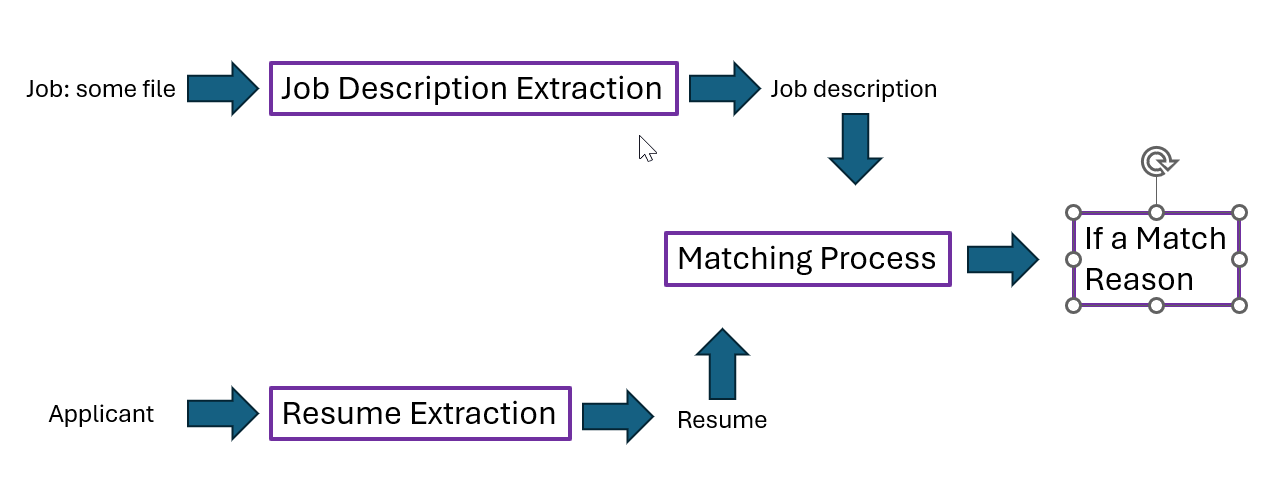

In [58]:
Image(filename= "tutorial/LLM+Langchain/Week-3/LCEL_3.png")

In [59]:
from operator import itemgetter

from langchain_core.runnables import RunnablePassthrough

# resume_pipeline: url -> a resume
# matching_pipeline: receive the resume and match it with the job description

step_1 = RunnablePassthrough.assign(resume=itemgetter("url")|resume_pipeline)
step_2 = matching_pipeline
e2e_chain = step_1|step_2

In [60]:
# in principle, job description is known because as an HR, you should have that

e2e_chain.invoke({"url": "https://www.freelancer.com/u/divyadhakecha1",
                  "job": job_description})

{'result': 'No',
 'reason': "The applicant has extensive experience in UI/UX and web development, but there is no mention of experience with ReactJS, which is a critical requirement for the Software Engineer position at Bridgespace Group. Additionally, the applicant's recent work experience does not align with the 4+ years of front-end development using ReactJS required for the role. The skills listed focus more on design and development using platforms like WordPress, Shopify, and Webflow, rather than the specific technologies and tools mentioned in the job description, such as Redux, Webpack, npm, and RESTful APIs."}

# N-Shot Learning

Imagine you have a friend who is incredibly good at understanding and completing tasks just by looking at a few examples. This is somewhat like how N-shot learning works with large language models (LLMs).

## What is N-Shot Learning?
N-shot learning is a way of teaching an AI model by giving it a small number of examples (N examples) for a particular task. Here's how it works:

- 1-Shot Learning: The AI is shown one example of the task and then asked to perform a similar task.
- Few-Shot Learning: The AI is shown a few examples (like 2, 3, or 5) of the task before it is asked to perform a similar task.
- Zero-Shot Learning: The AI is given instructions without any examples and asked to perform the task.

## Why is N-Shot Learning Useful?
Let's say you're teaching someone how to fold a paper airplane. If you show them just one way to fold it, that's 1-shot learning. If you show them three different ways, that's 3-shot learning. By seeing these examples, they can understand the general idea and apply it to fold new paper airplanes on their own.

## How Does This Work in AI?
For AI models, like the ones used in chatbots or virtual assistants, N-shot learning allows the model to learn from a few examples rather than needing thousands of examples. Here’s a simple analogy to explain it:

- Example Task: Writing a short story.
    - 1-Shot Example: You show the AI one short story and then ask it to write a similar story.
    - Few-Shot Example: You show the AI three different short stories and then ask it to write a new story.

By doing this, the AI understands patterns, structures, and styles from the examples provided and uses this understanding to generate new and relevant content.

## Benefits of N-Shot Learning
- Efficiency: It’s much faster and requires less data to train the AI.
- Versatility: The AI can quickly adapt to new tasks by being shown a few examples.
- Practicality: It’s similar to how humans learn, making it easier to apply in real-world situations.

## Real-World Application

Imagine a customer service AI that needs to answer queries. Instead of being trained with thousands of examples, you could use N-shot learning:

- Show it a few examples of customer queries and the appropriate responses.
- The AI learns the pattern and can then generate suitable responses for new queries.

In essence, N-shot learning helps AI models become smarter and more adaptable by learning from just a handful of examples, much like how we humans learn from a few demonstrations before we can do something on our own.

# N-Shot 學習

想像一下，你有一位朋友非常擅長理解和完成任務，只需要看幾個例子。這有點像 N-Shot 學習在大型語言模型（LLM）中的運作方式。

## 什麼是 N-Shot 學習？

N-Shot 學習 是通過給 AI 模型一些示例（N 個示例）來教它完成特定任務的一種方法。以下是它的運作方式：

- 1-Shot 學習：AI 只看到一個任務示例，然後被要求執行類似的任務。
- 少樣本學習（Few-Shot Learning）：AI 看到幾個（如 2、3 或 5 個）任務示例，然後被要求執行類似的任務。
- 零樣本學習（Zero-Shot Learning）：AI 只給出指令而不提供任何示例，然後被要求執行任務。

## 為什麼 N-Shot 學習有用？

假設你在教某人如何摺紙飛機。如果你只給他們看一個摺紙飛機的方法，這就是 1-Shot 學習。如果你給他們看三種不同的方法，這就是 3-Shot 學習。通過這些示例，他們可以理解大致的想法，並將其應用到摺新的紙飛機上。

## 這在 AI 中如何運作？

對於 AI 模型（如聊天機器人或虛擬助手中使用的模型），N-Shot 學習允許模型從少量示例中學習，而不需要成千上萬的示例。這裡有一個簡單的類比來解釋：

## 任務示例：寫一個短故事。

- 1-Shot 示例：你給 AI 看一個短故事，然後讓它寫一個類似的故事。
- Few-Shot 示例：你給 AI 看三個不同的短故事，然後讓它寫一個新的故事。
- 通過這樣做，AI 從提供的示例中理解模式、結構和風格，並使用這些理解來生成新的相關內容。

## N-Shot 學習的好處

- 效率高：訓練 AI 的速度更快，所需數據更少。
- 多功能性：AI 可以通過少量示例快速適應新任務。
- 實用性：這類似於人類學習的方式，使其更容易應用於現實世界的情況。

## 實際應用
想像一下，一個需要回答問題的客服 AI。與其用成千上萬的示例進行訓練，你可以使用 N-Shot 學習：
- 給它看一些客戶問題和適當回應的示例。
- AI 學習模式，然後可以為新問題生成合適的回應。

總之，N-Shot 學習幫助 AI 模型通過少量示例變得更聰明和更具適應性，就像我們人類通過幾次示範後就能獨立完成任務一樣。

In [61]:
Image(url="https://miro.medium.com/v2/resize:fit:720/format:webp/0*0eN5uwvq7JcesVex.png")

In [62]:
import re
import unicodedata
from typing import List

import tiktoken
from langchain_community.vectorstores import FAISS
from langchain.docstore.document import Document
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.retrievers import EnsembleRetriever
from langchain_core.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate

from src.io.path_definition import get_project_dir


encoder = tiktoken.encoding_for_model("gpt-4")


def remove_special_characters(text):
    # Step 1: Normalize to remove accents
    text = unicodedata.normalize('NFD', text)  # Decompose characters into base + accents
    text = ''.join([char for char in text if unicodedata.category(char) != 'Mn'])  # Remove accents

    text = re.sub(r'[^\w]', ' ', text)  # This removes all characters that are not word characters or spaces

    return text


def _preprocess_func(text: str) -> List[str]:

    text = remove_special_characters(text)

    # Lowercase the input text
    lowered = text.lower()

    # Convert the lowered text into tokens
    tokens = encoder.encode(lowered)

    # Stringify the tokens
    return [str(token) for token in tokens]


embedding = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

filename = os.path.join(get_project_dir(), 'tutorial', 'LLM+Langchain', 'Week-3', "benchmark.csv")

df_cosmetic = pd.read_csv(filename)

documents = []
 
for _, row in df_cosmetic.iterrows():
    document = Document(page_content=row['Description'],
                        metadata={"compound_category": row['compound_category']})
    documents.append(document)

vectorstore = FAISS.from_documents(documents, embedding=embedding)

embedding_retriever = vectorstore.as_retriever(search_type="similarity",
                                               search_kwargs={'k': 5})

bm25_retriever = BM25Retriever.from_documents(documents,
                                              k=5, bm25_params={"k1": 2.5},
                                              preprocess_func=_preprocess_func)

ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, embedding_retriever], weights=[0.5, 0.5]
)

C:\Users\MengChieh\AppData\Local\Temp\ipykernel_14264\2452660251.py:42: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
C:\Users\MengChieh\miniconda3\envs\aicg\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [63]:
from langchain_core.prompts.few_shot import FewShotChatMessagePromptTemplate

query = "Max Factor Colour Elixir Lipstick 837"

examples = ensemble_retriever.invoke(query)

example_inputs = []

for example in examples[1:]:
    example_inputs.append({"input": example.page_content, 
                           "output": example.metadata['compound_category']})
    

In [64]:
example_inputs

[{'input': 'Max Factor Colour Elixir Lipstick 853',
  'output': 'Colour;Lip;Lipstick'},
 {'input': 'Max Factor Colour Elixir Lipstick 715',
  'output': 'Colour;Lip;Lipstick'},
 {'input': 'Max Factor Colour Elixir Lipstick 894',
  'output': 'Colour;Lip;Lipstick'},
 {'input': 'Max Factor Colour Elixir Lipstick 825',
  'output': 'Colour;Lip;Lipstick'},
 {'input': 'Max Factor Colour Elixir Lipstick 685',
  'output': 'Colour;Lip;Lipstick'},
 {'input': 'Max Factor Colour Elixir Lipstick 025',
  'output': 'Colour;Lip;Lipstick'}]

### 2. Creating an Example Prompt (創建示例提示)

- This line creates a ChatPromptTemplate for the examples. It defines a conversation where the human's message is the input ({input}), and the AI's response is the output ({output}). This template will be used to format the examples consistently.
- 這行代碼為示例創建了一個 ChatPromptTemplate。它定義了一個對話，其中人類的訊息是輸入（{input}），AI 的回應是輸出（{output}）。這個模板將用於一致地格式化示例。

In [65]:
example_prompt = ChatPromptTemplate.from_messages(
    [('human', '{input}'), ('ai', '{output}')]
)

### 3. Creating a Few-Shot Prompt Template (創建少樣本提示模板)

- This line creates a FewShotChatMessagePromptTemplate. It takes the example_prompt and the list of example_inputs as arguments. This template will use the provided examples to guide the AI in generating responses, mimicking the structure of the examples.
- 這行代碼創建了一個 FewShotChatMessagePromptTemplate。它將 example_prompt 和 example_inputs 列表作為參數。該模板將使用提供的示例來指導 AI 生成回應，模仿示例的結構。

In [66]:
few_shot_message = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=example_inputs,
)

In [67]:
few_shot_message.format_prompt

<bound method BaseChatPromptTemplate.format_prompt of FewShotChatMessagePromptTemplate(examples=[{'input': 'Max Factor Colour Elixir Lipstick 853', 'output': 'Colour;Lip;Lipstick'}, {'input': 'Max Factor Colour Elixir Lipstick 715', 'output': 'Colour;Lip;Lipstick'}, {'input': 'Max Factor Colour Elixir Lipstick 894', 'output': 'Colour;Lip;Lipstick'}, {'input': 'Max Factor Colour Elixir Lipstick 825', 'output': 'Colour;Lip;Lipstick'}, {'input': 'Max Factor Colour Elixir Lipstick 685', 'output': 'Colour;Lip;Lipstick'}, {'input': 'Max Factor Colour Elixir Lipstick 025', 'output': 'Colour;Lip;Lipstick'}], input_variables=[], input_types={}, partial_variables={}, example_prompt=ChatPromptTemplate(input_variables=['input', 'output'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], input_types={}, partial_variables={}, template='{input}'), additional_kwargs={}), AIMessagePromptTemplate(prompt=PromptTemplate(input_varia

In [69]:
response_schemas = [
            ResponseSchema(name="category", description="""
                                                        product category. It must be from one of the LABEL.
                                                        In case you do not know the answer, reply `MinorityHierarchy`
                                                     """),
            ResponseSchema(name="reason", description="""
                                                    why you make such as decision.`
                                                    """)
        ]

output_parser = StructuredOutputParser.from_response_schemas(response_schemas)

format_instructions = output_parser.get_format_instructions()


n_shot_system_template = """
                          You are a helpful assistant. You are assigned with a task of identifying the CATEGORY of a PRODUCT.
        
                          CATEGORY is from one of the following:
        
                          - `Colour;Eye;Eye Pencil`
                          - `Colour;Eye;Eye Specials`
                          - `Colour;Eye;Eyeliner`
                          - `Colour;Eye;Eyeshadow`
                          - `Colour;Eye;Mascara`
                          - `Colour;Face;Blush + Highlighter`
                          - `Colour;Face;Body/Other`
                          - `Colour;Face;Concealer`
                          - `Colour;Face;Make-up`
                          - `Colour;Face;Powder + Bronzer`
                          - `Colour;Lip;Lip Pencil`
                          - `Colour;Lip;Lip Specials / Others`
                          - `Colour;Lip;Lipgloss`
                          - `Colour;Lip;Lipstick`
                          - `Colour;Nail;Base & Top Coats`
                          - `Colour;Nail;French Manicure`
                          - `Colour;Nail;Nail Art`
                          - `Colour;Nail;Nail Care`
                          - `Colour;Nail;Nailpolish`
                          - `Colour;Nail;Professional Nails`
                          - `Fragrance;Eau de toilette`
                          - `Hand Cream;Care`
                          - `Pure Skin;Cleanser`
                
                          """

system_prompt = PromptTemplate(template=n_shot_system_template)

system_message = SystemMessagePromptTemplate(prompt=system_prompt)

human_prompt = PromptTemplate(template="""
                                       What is the CATEGORY of {input}?

                                       format instruction: {format_instructions}
                                       """,
                               partial_variables={"format_instructions": format_instructions})

human_message = HumanMessagePromptTemplate(prompt=human_prompt) 

chat_prompt = ChatPromptTemplate.from_messages([system_message,
                                                few_shot_message,
                                                human_message
                                               ])


In [70]:
chat_prompt.invoke({"input": query})

ChatPromptValue(messages=[SystemMessage(content='\n                          You are a helpful assistant. You are assigned with a task of identifying the CATEGORY of a PRODUCT.\n        \n                          CATEGORY is from one of the following:\n        \n                          - `Colour;Eye;Eye Pencil`\n                          - `Colour;Eye;Eye Specials`\n                          - `Colour;Eye;Eyeliner`\n                          - `Colour;Eye;Eyeshadow`\n                          - `Colour;Eye;Mascara`\n                          - `Colour;Face;Blush + Highlighter`\n                          - `Colour;Face;Body/Other`\n                          - `Colour;Face;Concealer`\n                          - `Colour;Face;Make-up`\n                          - `Colour;Face;Powder + Bronzer`\n                          - `Colour;Lip;Lip Pencil`\n                          - `Colour;Lip;Lip Specials / Others`\n                          - `Colour;Lip;Lipgloss`\n                          

In [71]:
pipeline = chat_prompt|model|output_parser

output = pipeline.invoke({"input":query})

print(output)

{'category': 'Colour;Lip;Lipstick', 'reason': "The product name 'Max Factor Colour Elixir Lipstick 837' clearly indicates that it is a lipstick. The category for lipsticks is 'Colour;Lip;Lipstick'."}


## Can we chain this together with LCEL?

In [ ]:
from operator import itemgetter

from langchain_core.runnables import RunnableLambda, RunnableParallel, RunnablePassthrough

In [ ]:
def build_standard_chat_prompt_template_v2(kwargs):

    messages = []
    
    for key in ['system', 'few_shot', 'human']:
        if kwargs.get(key):
            if key == 'system':
                system_content = kwargs['system']
                system_prompt = PromptTemplate(**system_content)
                message = SystemMessagePromptTemplate(prompt=system_prompt)
            elif key == 'human':
                human_content = kwargs['human']
                human_prompt = PromptTemplate(**human_content)
                message = HumanMessagePromptTemplate(prompt=human_prompt)
            else:
                few_shot_content = kwargs['few_shot']
                message = FewShotChatMessagePromptTemplate(**few_shot_content)
            
            messages.append(message)
    
    chat_prompt = ChatPromptTemplate.from_messages(messages)

    return chat_prompt

In [ ]:
@chain
def few_shot_prompt_fn(data):

    example_prompt = ChatPromptTemplate.from_messages(
        [('human', '{input}'), ('ai', '{output}')]
    )

    examples = []
    
    for example in data['examples']:
        examples.append({"input": example.page_content, 
                         "output": example.metadata['compound_category']})
    
    few_shot_prompt = FewShotChatMessagePromptTemplate(
        example_prompt=example_prompt,
        examples=examples
    )

    human_template = """
                     What is the CATEGORY of {input}?

                     format instruction: {format_instructions}
                     """
    
    input_ = {"system": {"template": n_shot_system_template},
              "human": {"template": human_template,
                        "partial_variables": {"format_instructions": format_instructions}},
              "few_shot": {"example_prompt": example_prompt,
                           "examples": examples}}
    
    prompt_template = build_standard_chat_prompt_template_v2(input_)

    return prompt_template

In [ ]:
pipeline_ = {"examples": ensemble_retriever,
             "input": RunnablePassthrough()}|few_shot_prompt_fn|model|output_parser

In [ ]:
pipeline_.invoke(query)

### Any other possibilities?

The code above was finished by the end of July.

In [ ]:
from langchain_core.example_selectors import SemanticSimilarityExampleSelector

SemanticSimilarityExampleSelector?

In [ ]:
example_prompt = PromptTemplate(
    input_variables=["input", "output"],
    template="human: {input}\nai: {output}",
)

examples = []

for _, row in df_cosmetic.iterrows():

    examples.append({"input": row['Description'],
                     "output": row['compound_category']})

In [ ]:
from langchain_core.prompts import FewShotPromptTemplate, PromptTemplate


embedding = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

example_selector = SemanticSimilarityExampleSelector.from_examples(
    # The list of examples available to select from.
    examples=examples,
    # The embedding class used to produce embeddings which are used to measure semantic similarity.
    embeddings=embedding,
    # The VectorStore class that is used to store the embeddings and do a similarity search over.
    vectorstore_cls=FAISS,
    # The number of examples to produce.
    k=4,
)

## FewShotPromptTemplate here, instead of FewShotChatMessagePromptTemplate

similar_prompt = FewShotPromptTemplate(
    # We provide an ExampleSelector instead of examples.
    example_selector=example_selector,
    example_prompt=example_prompt,
    prefix=n_shot_system_template,
    suffix="""
           What is the CATEGORY of {input}?

           format instruction: {format_instructions}
           """,
    input_variables=["input"],
    partial_variables={"format_instructions": format_instructions}
)

In [ ]:
pipeline = similar_prompt|model|output_parser

In [ ]:
pipeline.invoke({"input": query})

### 回家作業 3

https://python.langchain.com/v0.1/docs/modules/model_io/prompts/example_selectors/similarity/

1. 替換掉examples
<!-- 2. 替換OpenAIEmbeddings()為HuggingFaceEmbeddings -->
3. 替換掉k值。假設為5-shot